In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from src.utils import util, data_loaders
from src.utils.domain_split import hyperplane_split
from src.model import MLP
from src.train_test import fit_regr, test_regr

# seed = 1
seed = npr.randint(10000)
seed = 4963
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('../../data/regression/boston.csv', header=None, delimiter=r"\s+", names=column_names)
df = df.drop(columns=['CRIM', 'ZN', 'CHAS', 'RAD', 'B'])
df.head()

,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,LSTAT,MEDV
0,2.31,0.538,6.575,65.2,4.0900,296.0,15.3,4.98,24.0
1,7.07,0.469,6.421,78.9,4.9671,242.0,17.8,9.14,21.6
2,7.07,0.469,7.185,61.1,4.9671,242.0,17.8,4.03,34.7
3,2.18,0.458,6.998,45.8,6.0622,222.0,18.7,2.94,33.4
4,2.18,0.458,7.147,54.2,6.0622,222.0,18.7,5.33,36.2


In [3]:
D = df.values
dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1, seed=seed)
df[dom_idx].head()

Found random direction n = [ 0.21437113 -0.59235263  0.33281996  0.13095121 -0.11053209  0.13295995
  0.54390077 -0.2203249  -0.3177723 ]
Found split with ratio r = 0.19960474308300397


,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,LSTAT,MEDV
1,7.07,0.469,6.421,78.9,4.9671,242.0,17.8,9.14,21.6
2,7.07,0.469,7.185,61.1,4.9671,242.0,17.8,4.03,34.7
3,2.18,0.458,6.998,45.8,6.0622,222.0,18.7,2.94,33.4
4,2.18,0.458,7.147,54.2,6.0622,222.0,18.7,5.33,36.2
5,2.18,0.458,6.430,58.7,6.0622,222.0,18.7,5.21,28.7


In [4]:
# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

In [5]:
# Hyperparameters
n_features = X_train.shape[1]
n_classes = 1
n_hidden_1 = 100
n_hidden_2 = 30
network = [n_hidden_1, n_hidden_2]
activation = 'abs'
n_epochs = 10000
learning_rate = 0.0001
weight_decay = 1e-5
batch_size = 64

In [6]:
# Transformation required for regression problem
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_OOD = y_OOD.reshape(-1, 1)

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size, device)

In [16]:
boston_model = MLP(n_features, 1, [100, 30], 'relu', batch_norm=False).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(boston_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [17]:
train_losses = fit_regr(boston_model, loss_function, optimizer, train_loader, n_epochs=n_epochs,
                        verbose=1, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")
print(f"Total Train MSE: {len(X_train) * avg_train_loss:.5f}")

Loss on dev set has stopped decreasing after epoch 1845 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE: 0.00004
Total Train MSE: 0.01403


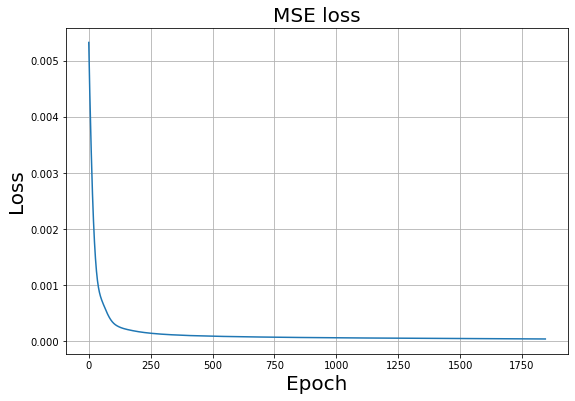

In [18]:
plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

In [19]:
avg_test_loss = test_regr(boston_model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   
print(f"Total test MSE: {len(X_test) * avg_train_loss:.5f}")

Average test MSE = 0.00007
Total test MSE: 0.00351


In [20]:
avg_OOD_loss = test_regr(boston_model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

Average OOD loss = 0.0008401566
Average OOD loss to train loss ratio:  19.401
Average OOD loss to test loss ratio:  12.574


### Abs


Average Train MSE: 0.00003


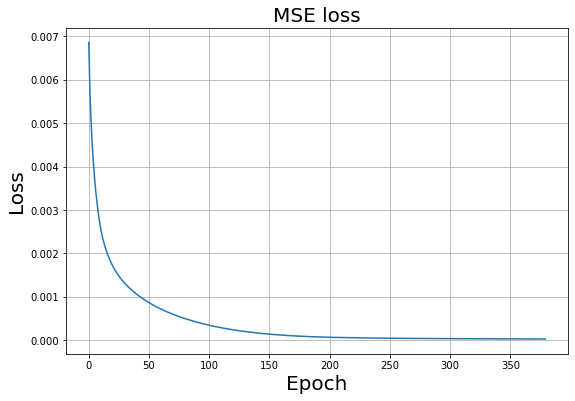

Average test MSE = 0.00075
Average OOD loss = 0.0049739425
Average OOD loss to train loss ratio:  173.260
Average OOD loss to test loss ratio:  6.624


In [7]:
model = MLP(n_features, 1, network, activation, batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train
train_losses = fit_regr(model, loss_function, optimizer, train_loader, 
    n_epochs=n_epochs, verbose=0, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")  

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

avg_test_loss = test_regr(model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   

avg_OOD_loss = test_regr(model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

In [8]:
def pipeline(X_train, X_test, y_train, y_test, verbose=0):
    
    # Transformation required for regression problem
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
    test_loader = data_loaders.create_loader(test_dataset, batch_size, device)

    # Model setup
    boston_model = MLP(n_features, 1, network, activation).to(device)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(boston_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # fit function optionally returns a list with the epoch-wise losses
    train_loss = fit_regr(boston_model, loss_function, optimizer, train_loader, 
                 n_epochs=n_epochs, verbose=1, early_stopping=True, return_losses=True) 
    test_loss = test_regr(boston_model, loss_function, test_loader, verbose=0, return_loss=True) 
    
    if verbose:
        print(f"Average Train MSE Loss: {train_loss[-1] : .10f}")
        print(f"Average Test MSE Loss : {test_loss : .10f}" )

    return train_loss, test_loss                 # train loss is a list, test loss is a float
 


Training on fold no. 1
Loss has stopped decreasing after epoch 803 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001710909
Average Test MSE Loss :  0.0032630003

Training on fold no. 2
Loss has stopped decreasing after epoch 536 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001654271
Average Test MSE Loss :  0.0019892431

Training on fold no. 3
Loss has stopped decreasing after epoch 612 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001871663
Average Test MSE Loss :  0.0050166740

Training on fold no. 4
Loss has stopped decreasing after epoch 566 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001269678
Average Test MSE Loss :  0.0022911488

Training on fold no. 5
Loss has stopped decreasing after epoch 639 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001620887
Average Test MSE Loss :  0.0020479491

Training on fold no. 6
Loss has stopped decreasing after epoch 632 (average of 

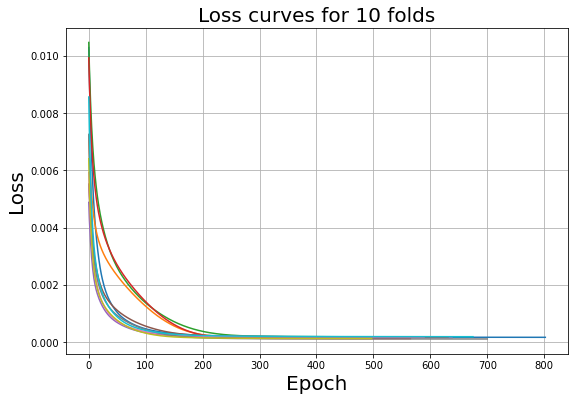

In [9]:
n_splits = 10
kf = KFold(n_splits)

train_losses = np.zeros(n_splits)
test_losses = np.zeros(n_splits)
train_losses_plot = []                           # for plotting loss curves
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("\nTraining on fold no. %d" %(i+1))
    epoch_wise_train_losses, test_losses[i] = pipeline(X_train, X_test, y_train, y_test, verbose=1)
    train_losses[i] = epoch_wise_train_losses[-1]
    train_losses_plot.append(epoch_wise_train_losses)
    
print("\nTrain losses:", train_losses)
print("\nTest losses:", test_losses)

avg_train_loss_k_folds = train_losses.mean() 
avg_test_loss_k_folds = test_losses.mean() 
print(f"\nAvg train loss over all folds: {avg_train_loss_k_folds :.5f}")
print(f"Avg total train loss over all folds: {len(X_train) * avg_train_loss_k_folds :.5f}")
print(f"\nAvg test loss over all folds: {avg_test_loss_k_folds :.5f}")
print(f"Avg total test loss over all folds: {len(X_test) * avg_test_loss_k_folds :.5f}")

plt.figure(figsize=(9,6))
for losses in train_losses_plot:
    plt.plot(losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title(f"Loss curves for {n_splits} folds", fontsize=20)
plt.show()